In [60]:
# Show plots as part of the notebook (this is a Jupyter-specific operation)
%matplotlib inline
import time
import matplotlib.pyplot as plt
import requests
import xmltodict
# Standard library packages
import os

# Import Pandas and Seaborn
import pandas as pd
import seaborn as sns
import numpy as np

# Import Biopython tools for running local BLASTX
from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast.Applications import NcbiblastnCommandline

#For execution time tracking
from datetime import datetime
from pytz import timezone

In [2]:
now_time = datetime.now(timezone('America/Chicago'))
print(now_time.strftime('%I:%M:%S %p'))

11:18:40 AM


In [48]:
%%time
df = pd.read_csv('01_db_blastn_July142020_filtered_1e-20_subj.csv')

CPU times: user 16.9 s, sys: 2.97 s, total: 19.8 s
Wall time: 19.8 s


In [49]:
df['subject'].nunique()

10033

In [50]:
df = df['subject'].value_counts()
df = pd.Series(df)
df

JAGRRH010000013.1    74211
LR877147.1           44319
LR877155.1           36624
KM198929.1           32369
NC_038215.1          32052
                     ...  
DQ911828.1               1
DQ911807.1               1
FM992003.1               1
LN735273.1               1
AY544249.1               1
Name: subject, Length: 10033, dtype: int64

In [51]:
df.to_csv('01_1_db_blastn_July142020_filtered_1e-20_subj_to_7level_taxonomy.csv')

In [52]:
df = pd.read_csv('01_1_db_blastn_July142020_filtered_1e-20_subj_to_7level_taxonomy.csv')

In [53]:
df.head()

,Unnamed: 0,subject
0,JAGRRH010000013.1,74211
1,LR877147.1,44319
2,LR877155.1,36624
3,KM198929.1,32369
4,NC_038215.1,32052


In [54]:
df.columns.values[0] = "subject"
df.columns.values[1] = "count"

In [56]:
df.to_csv('01_1_db_blastn_July142020_filtered_1e-20_subj_to_7level_taxonomy.csv', index= False)

In [57]:
df = pd.read_csv('01_1_db_blastn_July142020_filtered_1e-20_subj_to_7level_taxonomy.csv')

In [58]:
df.head()

,subject,count
0,JAGRRH010000013.1,74211
1,LR877147.1,44319
2,LR877155.1,36624
3,KM198929.1,32369
4,NC_038215.1,32052


## Retrieving (efetch) taxonomy heirarchy from NCBI

In [59]:
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/{}"
db = "nuccore"

In [60]:
def get_taxon_name(tax_id):
    try:
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        Definition = efetch_dict['GBSet']['GBSeq']['GBSeq_definition']
        Definition = Definition.split(',')
        Definition = Definition[0]
        time.sleep(0.5)
    except:
        Definition = tax_id
        pass
 
    return Definition

In [61]:
get_taxon_name ('NC_016703.1')

'Phaeocystis antarctica plastid'

In [62]:
def get_7level_taxonomy(tax_id):
    try:   
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        GBSeq_taxonomy = efetch_dict['GBSet']['GBSeq']['GBSeq_taxonomy']
#        GBSeq_taxonomy_class = GBSeq_taxonomy.split("; ")
#        GBSeq_taxonomy_class = GBSeq_taxonomy_class[2]
        time.sleep(0.5)
    except:
        GBSeq_taxonomy = tax_id
        pass
    
    return GBSeq_taxonomy

In [63]:
get_7level_taxonomy ('NC_016703.1')

'Eukaryota; Haptophyceae; Phaeocystales; Phaeocystaceae; Phaeocystis'

In [64]:
df.head()

,subject,count
0,JAGRRH010000013.1,74211
1,LR877147.1,44319
2,LR877155.1,36624
3,KM198929.1,32369
4,NC_038215.1,32052


In [65]:
df['subject']

0        JAGRRH010000013.1
1               LR877147.1
2               LR877155.1
3               KM198929.1
4              NC_038215.1
               ...        
10028           DQ911828.1
10029           DQ911807.1
10030           FM992003.1
10031           LN735273.1
10032           AY544249.1
Name: subject, Length: 10033, dtype: object

In [66]:
%%time
def enrich_dataset(df):
    taxon_value = df['subject']
    Seven_Level_Taxonomy = get_7level_taxonomy(taxon_value)
    df['7Level_Taxonomy'] = Seven_Level_Taxonomy
    return df

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 23.1 µs


In [67]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 7min 32s, sys: 32 s, total: 8min 4s
Wall time: 4h 7min 12s


In [68]:
df.to_csv('04_db_blastn_July142020_filtered_1e-20_subj_to_7level_taxonomy_enriched.csv', index= False)

# Process Taxonomic Levels, Extract Information

In [201]:
df = pd.read_csv('04_db_blastn_July142020_filtered_1e-20_subj_to_7level_taxonomy_enriched.csv')

In [202]:
df['7Level_Taxonomy'].nunique()

965

In [203]:
df.head(5)

,subject,count,7Level_Taxonomy
0,JAGRRH010000013.1,74211,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...
1,LR877147.1,44319,Eukaryota; Discoba; Euglenozoa; Kinetoplastea;...
2,LR877155.1,36624,Eukaryota; Discoba; Euglenozoa; Kinetoplastea;...
3,KM198929.1,32369,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...
4,NC_038215.1,32052,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...


In [204]:
def taxlevel (tax):
    tax = tax.split("; ")
    tax_len = len(tax)
    
    return tax_len

In [205]:
def enrich_dataset(df):
    taxon_level = df['7Level_Taxonomy']
    Seven_Level_Taxonomy = taxlevel(taxon_level)
    df['7Level_Lenght'] = Seven_Level_Taxonomy
    return df

In [206]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 5.98 s, sys: 65.4 ms, total: 6.05 s
Wall time: 6.05 s


In [213]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght
0,JAGRRH010000013.1,74211,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10
1,LR877147.1,44319,Eukaryota; Discoba; Euglenozoa; Kinetoplastea;...,9
2,LR877155.1,36624,Eukaryota; Discoba; Euglenozoa; Kinetoplastea;...,9
3,KM198929.1,32369,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...,4
4,NC_038215.1,32052,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...,4


In [211]:
df['7Level_Lenght'].value_counts()

2     2299
6     2152
9     1179
8      979
4      951
7      810
10     524
5      429
3      348
11     262
1      100
Name: 7Level_Lenght, dtype: int64

In [233]:
df.shape

(10033, 5)

In [220]:
df["Levels"] = df["7Level_Lenght"].replace({11: "11_Levels",
                                           10: "10_Levels",
                                           9: "9_Levels",
                                           8: "8_Levels",
                                           7: "7_Levels",
                                           6: "6_Levels",
                                           5: "5_Levels",
                                           4: "4_Levels",
                                           3: "3_Levels",
                                           2: "2_Levels",
                                           1: "1_Level",
                                           })

In [221]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght,Levels
0,JAGRRH010000013.1,74211,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10,10_Levels
1,LR877147.1,44319,Eukaryota; Discoba; Euglenozoa; Kinetoplastea;...,9,9_Levels
2,LR877155.1,36624,Eukaryota; Discoba; Euglenozoa; Kinetoplastea;...,9,9_Levels
3,KM198929.1,32369,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...,4,4_Levels
4,NC_038215.1,32052,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...,4,4_Levels


<AxesSubplot:>

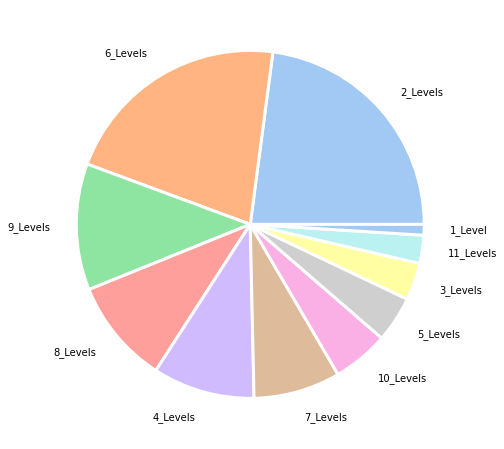

In [253]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='')

<AxesSubplot:>

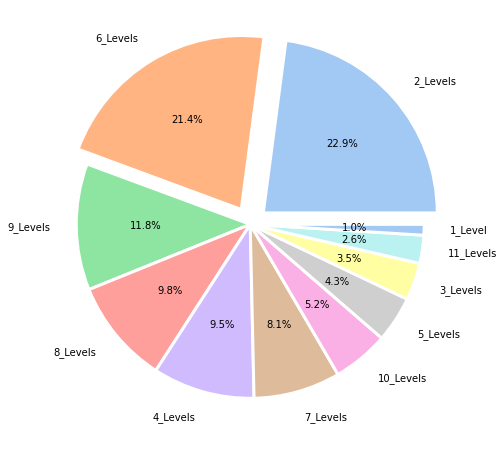

In [267]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
explode = (0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='',
                                     autopct='%1.1f%%',
                                     explode = explode)

<AxesSubplot:>

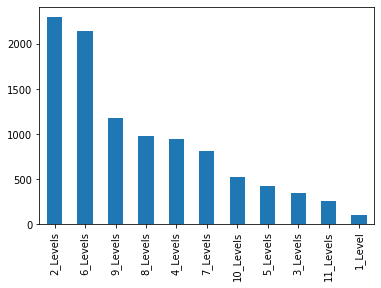

In [235]:
df['Levels'].value_counts().plot.bar()

##### Saving the count of taxonomic levels of each subject (blasted accession numbers from Nucleotide database of NCBI)

In [268]:
df.to_csv('05_db_blastn_July142020_filtered_1e-20_subj_to_7level_taxonomy_enriched.csv', index= False)